
### US ECO MODEL: GLOBAL OECD DIFFUSION INDEX
- Model: Economic Time Series Signal adjusted for publication lag of the series
- Trading frequency: monthly
- Universe & Time Period:
    - S&P500 index: 1960 - Nov 2022
    - Global OECD diffusion index: 1960 - Nov 2022
- Simple rules:
    - If the diffusion index > 50%: invest in S&P500
    - If the diffusion index <50%: invest in Tbills.
   
- Technical:
    - Diffusion index: percentage of countries with a rising OECD-indicator (month- over-month)
- **_Remarks_**:
    - OECD series is shifted one month (conservative) to take into account the publication lag.
    - Trading costs: 20 bps 
    - Dividends are not taken into account.
    - Any mistakes remain mine. If you find any, please do let me know so I can rectify. Thank you!


In [38]:
!pip install pandasdmx
!pip install empiricaldist

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [41]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import yfinance as yf
import datetime as dt
import json
from dateutil.relativedelta import relativedelta
import pandasdmx as pdmx
import scipy.stats as ss
import empiricaldist as emp
import seaborn as sns


In [17]:
# Tell pdmx we want OECD data
oecd = pdmx.Request("OECD")
# Set out everything about the request in the format specified by the OECD API
data = oecd.data(resource_id="MEI_CLI",key="LOLITOAA.AUS+AUT+BEL+CAN+CHL+CZE+DNK+EST+FIN+FRA+DEU+GRC+HUN+IRL+ISR+ITA+JPN+KOR+LUX+MEX+NLD+NZL+NOR+POL+PRT+SVK+SVN+ESP+SWE+CHE+TUR+GBR+USA+BRA+CHN+IND+IDN+RUS+ZAF.M/all?startTime=1947-02&endTime=2023-02").to_pandas()

oecd_df = pd.DataFrame(data).reset_index()


In [18]:
#list of unique dates (used to loop below)
dates=list(oecd_df['TIME_PERIOD'].unique())
dates=sorted(dates)
#Build a dictionary with dates as keys and the % of countries with a rising OECD value month over month as values
oecd_perc={}
for date in dates:
    prev_date=dates[dates.index(date)-1]
    mask=oecd_df['TIME_PERIOD']==date
    country_list=list(oecd_df[mask]['LOCATION'].unique())
    total=len(country_list)   
    counter=[]
    for country in country_list:
        val=oecd_df.loc[(oecd_df['LOCATION']==country)&(oecd_df['TIME_PERIOD']==date)]['value']
        valprev=oecd_df.loc[(oecd_df['LOCATION']==country)&(oecd_df['TIME_PERIOD']==prev_date)]['value']
        if val.empty|valprev.empty:
            counter.append(0)
        else:
            if val.item() > valprev.item():
                counter.append(1)
            else:
                counter.append(0)
    
        oecd_perc_date=sum(counter)/total
    oecd_perc[date]=oecd_perc_date   


In [23]:
#convert the dictionary to a datafraeme
oecd_df2=pd.DataFrame(data=oecd_perc.values(),index=oecd_perc.keys(),columns=['%_countries_rising'])
oecd_df2.index=pd.to_datetime(oecd_df2.index)

In [24]:
#Import S&P500 daily data as a series
start='1950-01-01'
SP500_price=yf.download("^GSPC",start)['Adj Close']

[*********************100%***********************]  1 of 1 completed


In [25]:
#Calculate monthly S&P500 returns in (1+R) format
SP500_dly=(SP500_price.pct_change()+1).dropna()
SP500_mtly=SP500_dly.resample('M').prod()

In [26]:
#Import Tbill data
Tbill_d=yf.download("^IRX",start)['Adj Close']
#Calculate monthly returns in (1+R) format
Tbill_dr=Tbill_d/100/252+1
Tbill_mtly=Tbill_dr.resample('M').prod()

[*********************100%***********************]  1 of 1 completed


In [27]:
#convert datetime to period and then back to timestamp to get end of dates
oecd_df2.index =oecd_df2.index.to_period('M').to_timestamp('M')
#add sp500 and tbills now to the dataframe now that dates are aligned
oecd_df2['SP500_monthly']=SP500_mtly
oecd_df2['Tbill_monthly']=Tbill_mtly
oecd_df2=oecd_df2.dropna()
oecd_df2
#calculate the signal: if % countries >=50%, then 0 otherwise 1. and then shift it a month for the mag
oecd_df2['Signal']=np.where(oecd_df2['%_countries_rising']>=0.5,1,0)
oecd_df2['Signal']=oecd_df2['Signal'].shift(1)
oecd_df2.dropna(inplace=True)

In [28]:
#calculate turnover
oecd_df2['TURN']=np.where(oecd_df2['Signal'].shift(1)!=oecd_df2['Signal'],1,0)
TO=oecd_df2['TURN'].mean()
#calculate monthly returns Strategy in (1+R) format 
oecd_df2['STRAT_monthly']=np.where(oecd_df2['Signal'].shift(1)==1,oecd_df2['SP500_monthly'],oecd_df2['Tbill_monthly'])
#Take into account a transaction cost
commission=0.998
oecd_df2['STRAT_monthly_net']=np.where(oecd_df2['Signal'].shift(2)!=oecd_df2['Signal'].shift(1),oecd_df2['STRAT_monthly']*commission,oecd_df2['STRAT_monthly'])
#Build a wealth index of Tbills,SP500 and strategy for performance comparison
oecd_df2['TBILL_index']=oecd_df2['Tbill_monthly'].cumprod()
oecd_df2['SP500_index']=oecd_df2['SP500_monthly'].cumprod()
oecd_df2['STRAT_index']=oecd_df2['STRAT_monthly_net'].cumprod()
#relative performance
oecd_df2['RELATIVE']=oecd_df2['STRAT_index']/oecd_df2['SP500_index']

In [29]:
#save the strat return series to CSV
strat_return_series=oecd_df2['STRAT_monthly_net']-1
strat_return_series.index.rename('date',inplace=True)
strat_return_series.name='oecd_diffusion_return'
strat_return_series.to_csv('oecd_diffusion_return.csv')

In [30]:
#PERFORMANCE METRICS: still need beta, capm alpha, 3 factor alpha, excess return, Ulcer, longest dradown duration, longest recovery
#Turnover
TA=(((1+TO)**12)-1)*100
#YearFrac
YearFraq=oecd_df2.shape[0]/12
#correlation between strategy and bench
Cor=oecd_df2["STRAT_monthly"].corr(oecd_df2['SP500_monthly'])
#Annualized Returns
RiskFree_ar=(oecd_df2['TBILL_index'][-1]-1)**(1/YearFraq)-1
Strat_ar=(oecd_df2['STRAT_index'][-1]-1)**(1/YearFraq)-1
Bench_ar=(oecd_df2['SP500_index'][-1]-1)**(1/YearFraq)-1
#Best and worst period returns
Strat_best=oecd_df2['STRAT_monthly'].max()-1
Strat_worst=oecd_df2['STRAT_monthly'].min()-1
Bench_best=oecd_df2['SP500_monthly'].max()-1
Bench_worst=oecd_df2['SP500_monthly'].min()-1
#% profitable
Strat_Prof=(oecd_df2['STRAT_monthly']>1).mean()
Bench_Prof=(oecd_df2['SP500_monthly']>1).mean()
#AnnualizedVol
Strat_vol=oecd_df2['STRAT_monthly'].std()*np.sqrt(12)
Bench_vol=oecd_df2['SP500_monthly'].std()*np.sqrt(12)
#tracking error
ExcessRet=oecd_df2['STRAT_monthly']-oecd_df2['SP500_monthly']
TE=ExcessRet.std()*np.sqrt(12)
#InformationRatio
IR=(Strat_ar-Bench_ar)/TE                          
#Annualized Upside Vol (above o)
Strat_up=oecd_df2[oecd_df2['STRAT_monthly']>1]['STRAT_monthly'].std()*np.sqrt(12)
Bench_up=oecd_df2[oecd_df2['SP500_monthly']>1]['SP500_monthly'].std()*np.sqrt(12)
#Annualized Downside (below o)
Strat_semi=oecd_df2[oecd_df2['STRAT_monthly']<1]['STRAT_monthly'].std()*np.sqrt(12)
Bench_semi=oecd_df2[oecd_df2['SP500_monthly']<1]['SP500_monthly'].std()*np.sqrt(12)
#Sharpe
Strat_sharpe=(Strat_ar-RiskFree_ar)/Strat_vol
Bench_sharpe=(Bench_ar-RiskFree_ar)/Bench_vol
#Sortino
Strat_Sort=(Strat_ar-RiskFree_ar)/Strat_semi
Bench_Sort=(Bench_ar-RiskFree_ar)/Bench_semi
#skew of strategy and benchmark
Strat_skew=ss.skew(oecd_df2['STRAT_monthly']-1)
Bench_skew=ss.skew(oecd_df2['SP500_monthly']-1)
#Excess kurtosis of strategy and benchmark
Strat_kurt=ss.kurtosis(oecd_df2['STRAT_monthly']-1)
Bench_kurt=ss.kurtosis(oecd_df2['SP500_monthly']-1)
#Var of strategy and benchmark
Strat_r=oecd_df2['STRAT_monthly']-1
Strat_Var99=np.quantile(Strat_r,q=0.01)
Bench_r=oecd_df2['SP500_monthly']-1
Bench_Var99=np.quantile(Bench_r,q=0.01)
#CVAR of strategy and benchmark
Strat_Cvar99=Strat_r[Strat_r<Strat_Var99].mean()
Bench_Cvar99=Bench_r[Bench_r<Bench_Var99].mean()
#Parametric Gaussian VAR
Strat_Pvar99=Strat_ar+ss.norm.ppf(0.01)*Strat_vol
Bench_Pvar99=Bench_ar+ss.norm.ppf(0.01)*Bench_vol
#Drawdowns Strategy
Strat_max=oecd_df2['STRAT_index'].cummax()
Strat_dd=oecd_df2['STRAT_index']/Strat_max-1
#Drawdowns Index
Bench_max=oecd_df2['SP500_index'].cummax()
Bench_dd=oecd_df2['SP500_index']/Bench_max-1
#MaxDrawdown
Strat_md=min(Strat_dd)
Bench_md=min(Bench_dd)
#MAR since inception
Strat_r_to_md=Strat_ar/abs(Strat_md)
Bench_r_to_md=Bench_ar/abs(Bench_md)
#Put Everything in DataFrame
Output_dict={'Performance Metrics':['Correlation with benchmark','CAGR%','Best month','Worst month','% profitable','Vol','Upside Vol','Downside Vol','Sharpe Ratio','Sortino Ratio','Information Ratio','Tracking Error','Skewness','Excess Kurtosis','Historic Var (1%)','Historic Cvar (1%)','Gaussian Var (1%)','Max Drawdown %','MAR ratio','Average Turnover per Year'],
        'Strategy':['{:.2f}%'.format(Cor*100),'{:.2f}%'.format(Strat_ar*100),'{:.2f}%'.format(Strat_best*100),'{:.2f}%'.format(Strat_worst*100),'{:.2f}%'.format(Strat_Prof*100),'{:.2f}%'.format(Strat_vol*100),'{:.2f}%'.format(Strat_up*100),'{:.2f}%'.format(Strat_semi*100),'{:.2f}'.format(Strat_sharpe),'{:.2f}'.format(Strat_Sort),'{:.2f}'.format(IR),'{:.2f}%'.format(TE*100),'{:.2f}'.format(Strat_skew),'{:.2f}'.format(Strat_kurt),'{:.2f}%'.format(Strat_Var99*100),'{:.2f}%'.format(Strat_Cvar99*100),'{:.2f}%'.format(Strat_Pvar99*100),'{:.2f}%'.format(Strat_md*100),'{:.2f}'.format(Strat_r_to_md),'{:.2f}%'.format(TA)],
        'Benchmark':['-','{:.2f}%'.format(Bench_ar*100),'{:.2f}%'.format(Bench_best*100),'{:.2f}%'.format(Bench_worst*100),'{:.2f}%'.format(Bench_Prof*100),'{:.2f}%'.format(Bench_vol*100),'{:.2f}%'.format(Bench_up*100),'{:.2f}%'.format(Bench_semi*100),'{:.2f}'.format(Bench_sharpe),'{:.2f}'.format(Bench_Sort),'-','-','{:.2f}'.format(Bench_skew),'{:.2f}'.format(Bench_kurt),'{:.2f}%'.format(Bench_Var99*100),'{:.2f}%'.format(Bench_Cvar99*100),'{:.2f}%'.format(Bench_Pvar99*100),'{:.2f}%'.format(Bench_md*100),'{:.2f}'.format(Bench_r_to_md),'{:.2f}%'.format(0)]}

start=oecd_df2.index[0].strftime("%Y-%m")
end = oecd_df2.index[-1].strftime("%Y-%m")

Metrics=pd.DataFrame(Output_dict)
Metrics=Metrics.rename(columns={'Performance Metrics':'Performance Metrics '+'( '+start+' till '+end+ ')'})
Metrics

,Performance Metrics ( 1960-02 till 2023-02),Strategy,Benchmark
0,Correlation with benchmark,57.85%,-
1,CAGR%,8.08%,6.98%
2,Best month,13.18%,16.30%
3,Worst month,-12.51%,-21.76%
4,% profitable,81.37%,59.97%
5,Vol,8.66%,14.91%
6,Upside Vol,6.63%,8.98%
7,Downside Vol,6.88%,10.58%
8,Sharpe Ratio,0.44,0.18
9,Sortino Ratio,0.55,0.25


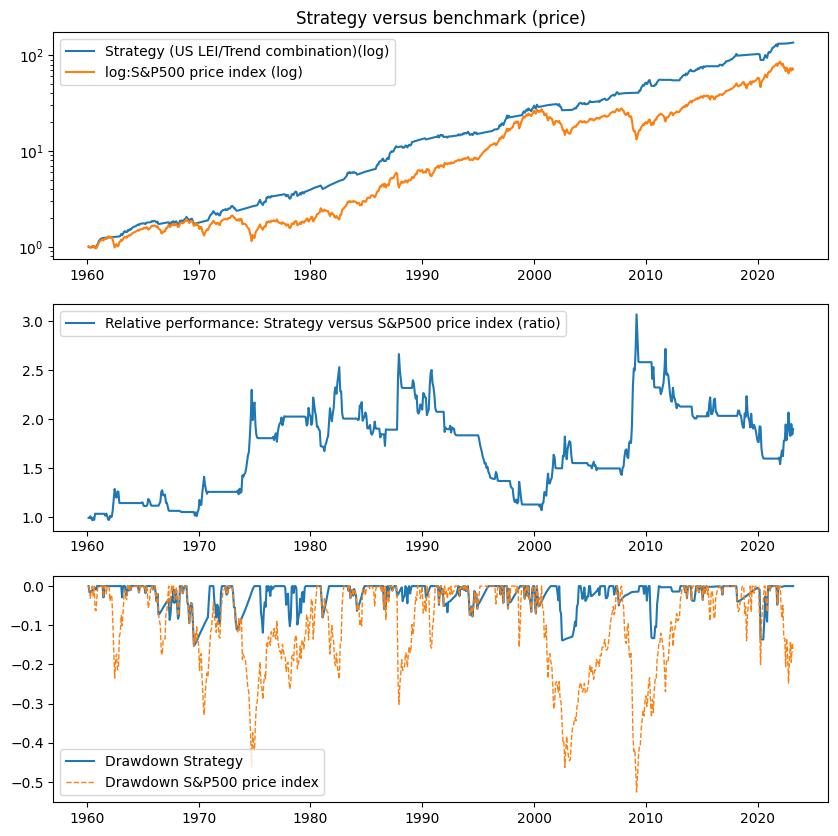

In [52]:
fig,ax=plt.subplots(3,1,figsize=(10,10))
ax[0].set_title("Strategy versus benchmark (price)")
ax[0].semilogy(oecd_df2['STRAT_index'],label="Strategy (US LEI/Trend combination)(log)")
ax[0].semilogy(oecd_df2['SP500_index'],label="log:S&P500 price index (log)")
ax[0].legend()
ax[1].plot(oecd_df2['RELATIVE'],label="Relative performance: Strategy versus S&P500 price index (ratio)")
ax[1].legend()
ax[2].plot(Strat_dd,label='Drawdown Strategy')
ax[2].plot(Bench_dd,label='Drawdown S&P500 price index',linestyle='--',linewidth=1)
ax[2].legend()
plt.savefig('strategy.png')
plt.show()


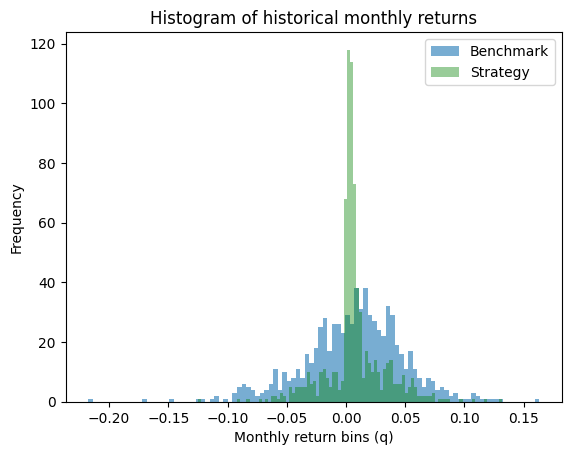

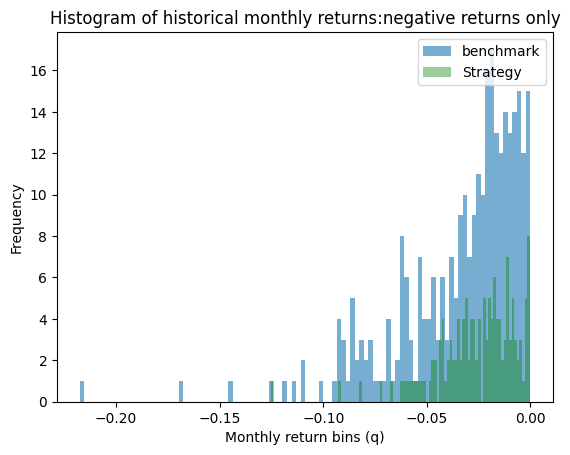

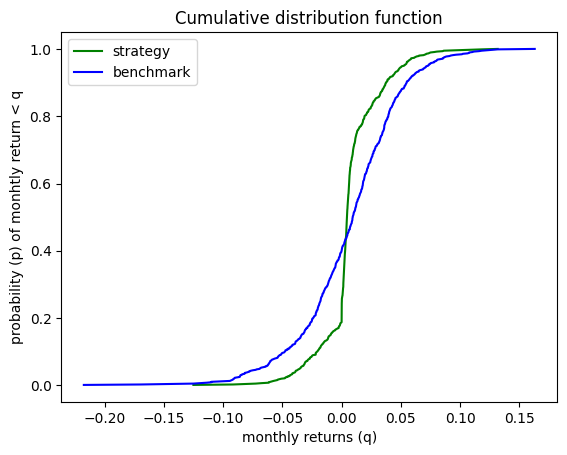

Benchmark: % of monthly returns below 0% is 40.03%
Strategy: % of monhtly returns below 0% is 18.63%


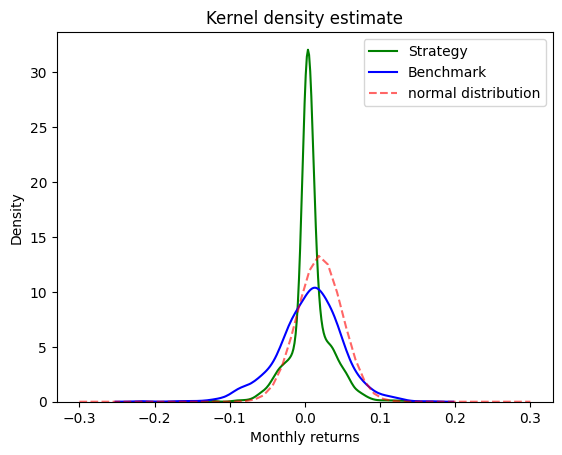

In [42]:
#Histogram of returns Bench and Strat
plt.hist(oecd_df2['SP500_monthly'].dropna()-1,bins=100,histtype='stepfilled',alpha=0.6,label='Benchmark')
plt.hist(oecd_df2['STRAT_monthly'].dropna()-1,bins=100,histtype='stepfilled',alpha=0.4,color='green',label='Strategy')
plt.title('Histogram of historical monthly returns')
plt.xlabel('Monthly return bins (q)')
plt.ylabel('Frequency')
plt.legend()
plt.show()
#Histogram of negative returns Bench and Strat
plt.hist(oecd_df2[oecd_df2['SP500_monthly']<1]['SP500_monthly'].dropna()-1,bins=100,histtype='stepfilled',alpha=0.6,label='benchmark')
plt.hist(oecd_df2[oecd_df2['STRAT_monthly']<1]['STRAT_monthly'].dropna()-1,bins=100,histtype='stepfilled',alpha=0.4,color='green',label='Strategy')
plt.title('Histogram of historical monthly returns:negative returns only')
plt.xlabel('Monthly return bins (q)')
plt.ylabel('Frequency')
plt.legend()
plt.show()
#Cumulative Distribution Function of  returns Bench and Strat
Strat_cdf=emp.Cdf.from_seq(oecd_df2['STRAT_monthly'].dropna()-1)
Bench_cdf=emp.Cdf.from_seq(oecd_df2['SP500_monthly'].dropna()-1)
plt.plot(Strat_cdf,color='green',label='strategy')
plt.plot(Bench_cdf,color='blue',label='benchmark')
plt.title("Cumulative distribution function")
plt.xlabel('monthly returns (q)')
plt.ylabel('probability (p) of monhtly return < q')
plt.legend()
plt.show()
print('Benchmark: % of monthly returns below 0% is {:.2f}%'.format(Bench_cdf(0)*100))
print('Strategy: % of monhtly returns below 0% is {:.2f}%'.format(Strat_cdf(0)*100))
#Kernel Distribution Estimate of strategy and benchmark
sns.kdeplot(oecd_df2['STRAT_monthly'].dropna()-1,label='Strategy',color='green')
sns.kdeplot(oecd_df2['SP500_monthly'].dropna()-1,label='Benchmark',color='blue')
x=np.linspace(-0.3,0.3)
y=ss.norm(0.02,0.03).pdf(x)
plt.plot(x,y,label= 'normal distribution',color='red',linestyle='--',alpha=0.6)
plt.title("Kernel density estimate")
plt.xlabel('Monthly returns')
plt.ylabel('Density')
plt.legend()
plt.show()

In [45]:
oecd_df2['Year']=oecd_df2.index.year
oecd_df2['Month']=oecd_df2.index.month

#create a pivot table of the strategy with strategy returns as values, years as rows and columns as as month values
Strat_pivot = oecd_df2.pivot(values='STRAT_monthly_net',index='Year',columns='Month')
#rename the columns labels with month names
months = ['Jan','Feb','March','April','May','June','July','Aug','Sep','Oct','Nov','Dec']
Strat_pivot.rename(columns=dict(enumerate(months,1)),inplace=True)
#Add a column that contains the total return for each year
Strat_pivot['Total']=Strat_pivot.prod(axis=1)
#get normal monhtly returns 
Strat_pivot=(Strat_pivot-1)*100

In [46]:
#create a function to style a dataframe that shows returns in pivot form
def style_df(df_):
    def style_negative(v, props=''):
        return props if v < 0 else None
    
    cell_hover = {
    "selector": "td:hover",
    "props": [("background-color", "#7FB3D5")]
    }
    index_names = {
    "selector": ".index_name",
    "props": "font-style: italic; color: white"
    }
    headers = {
    "selector": "th",
    "props": "background-color: #273746; color: white"
    }
    cells = {
    "selector": "td",
    "props": "background-color: white; font-size: 13px;font-family: sans-serif;border-collapse:collapse; border: 1px solid"
    }  
    x=df_.style\
        .applymap(style_negative, props='color:red;')\
        .format(formatter='{:,.2f}%',na_rep='-')\
        .set_table_styles([cell_hover,index_names, headers,cells])
    return x          

style_df(Strat_pivot)

Month,Jan,Feb,March,April,May,June,July,Aug,Sep,Oct,Nov,Dec,Total
Year,,,,,,,,,,,,,
1960,-,0.10%,-1.59%,0.06%,0.27%,0.21%,0.18%,0.21%,0.21%,-0.44%,4.03%,4.63%,7.97%
1961,6.32%,2.69%,2.55%,0.38%,1.91%,-2.88%,3.28%,0.02%,0.18%,0.19%,0.20%,0.21%,15.80%
1962,0.24%,0.20%,0.24%,0.22%,0.23%,0.23%,0.24%,0.26%,0.21%,0.24%,0.21%,1.15%,3.72%
1963,4.91%,-2.89%,3.55%,4.85%,1.43%,-2.02%,-0.35%,4.87%,-1.10%,3.22%,-1.05%,2.44%,18.89%
1964,2.69%,0.99%,1.52%,0.61%,1.15%,1.64%,1.82%,-1.62%,2.87%,0.81%,0.06%,0.34%,13.56%
1965,0.30%,-0.35%,-1.45%,3.42%,0.11%,0.33%,0.32%,0.34%,0.33%,2.53%,-0.88%,0.90%,5.96%
1966,0.49%,-1.79%,-2.18%,2.05%,-5.41%,0.19%,0.38%,0.45%,0.45%,0.43%,0.40%,0.41%,-4.25%
1967,0.39%,0.33%,0.37%,0.31%,-5.43%,1.75%,4.53%,-1.17%,3.28%,-3.53%,0.75%,2.63%,3.85%
1968,-4.38%,-3.12%,0.94%,8.05%,0.29%,0.71%,-1.85%,1.15%,3.85%,0.72%,4.80%,-4.16%,6.43%


Text(0.5, 1.0, 'Annual performance of the strategy (1960-now)')

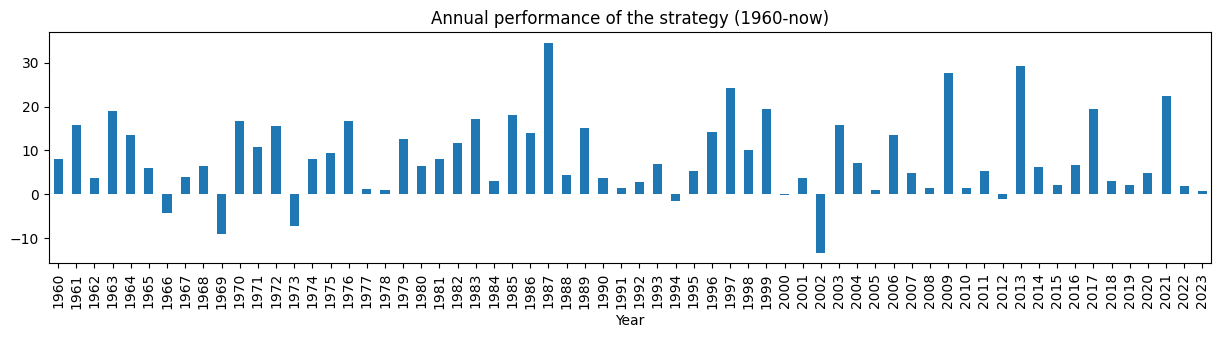

In [47]:
fig2,ax=plt.subplots(figsize=(15,3))
Strat_pivot['Total'].plot(kind='bar')
ax.set_title("Annual performance of the strategy (1960-now)")

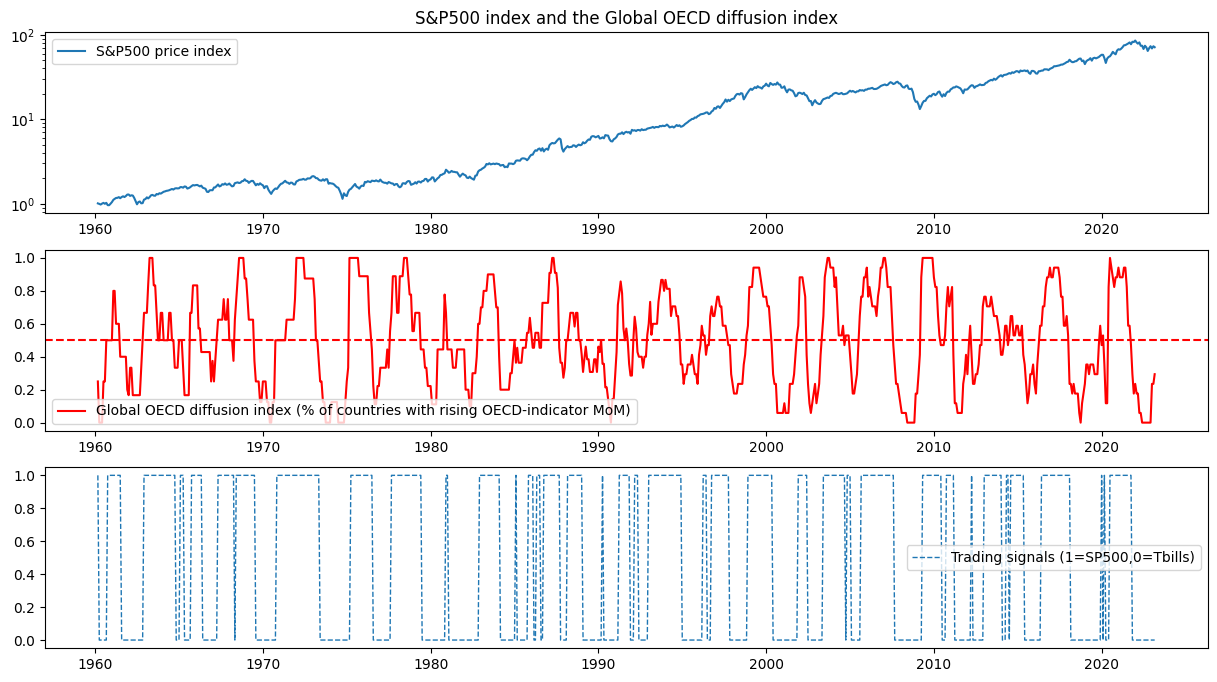

In [35]:
fig3,ax=plt.subplots(3,1,figsize=(15,8))
ax[0].set_title("S&P500 index and the Global OECD diffusion index")
ax[0].semilogy(oecd_df2['SP500_index'],label='S&P500 price index')
ax[0].legend()
ax[1].plot(oecd_df2['%_countries_rising'],label='Global OECD diffusion index (% of countries with rising OECD-indicator MoM)',color='red')
ax[1].axhline(y=0.5,color='red',linestyle='--')
ax[1].legend()
ax[2].plot(oecd_df2['Signal'],label='Trading signals (1=SP500,0=Tbills)',linewidth=1,linestyle='--')
ax[2].legend()

In [55]:
oecd_df2['%_countries_rising'].iloc[-1]

0.29411764705882354

In [36]:
#save figures
fig.savefig('strategy.png')
fig2.savefig('annual.png')
fig3.savefig('indicator.png')